## Programming Exercise 2 - Logistic Regression

- [Logistic regression](#Logistic-regression)
- [Regularized logistic regression](#Regularized-logistic-regression)

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [2]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ', data.shape)
    print(data[: 5,:])
    return data

In [3]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:, 2] == 0 # negative class
    pos = data[:, 2] == 1 # positive class
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
        
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True)

## Logistic regression

In [4]:
data = loaddata('data/ex2data1.txt', ',')

Dimensions:  (100, 3)
[[34.62365962 78.02469282  0.        ]
 [30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]]


In [5]:
X = np.c_[np.ones((data.shape[0],1)), data[:, 0], data[:, 1]]
y = data[:,2].reshape(-1,1)

In [6]:
print(X.shape, y.shape)

(100, 3) (100, 1)


In [7]:
X

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644],
       [ 1.        , 45.08327748, 56.31637178],
       [ 1.        , 61.10666454, 96.51142588],
       [ 1.        , 75.02474557, 46.55401354],
       [ 1.        , 76.0987867 , 87.42056972],
       [ 1.        , 84.43281996, 43.53339331],
       [ 1.        , 95.86155507, 38.22527806],
       [ 1.        , 75.01365839, 30.60326323],
       [ 1.        , 82.30705337, 76.4819633 ],
       [ 1.        , 69.36458876, 97.71869196],
       [ 1.        , 39.53833914, 76.03681085],
       [ 1.        , 53.97105215, 89.20735014],
       [ 1.        , 69.07014406, 52.74046973],
       [ 1.        , 67.94685548, 46.67857411],
       [ 1.        , 70.66150955, 92.92713789],
       [ 1.        , 76.97878373, 47.57596365],
       [ 1.        , 67.37202755, 42.838

In [8]:
y

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

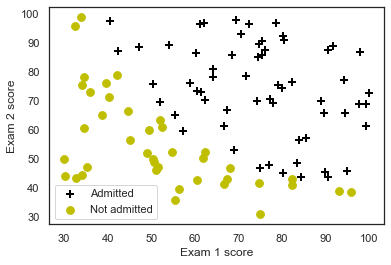

In [9]:
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

## Logistic regression hypothesis

$$ \large h_{\theta}(X) = g(\theta_0 + \theta_1 x_1 + \theta_2 x_2)$$

$$ \large h_{\theta}(X) = \frac{1}{1+e^{−(\theta_0 + \theta_1 x_1 + \theta_2 x_2)}}$$

In [10]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

Scipy actually has a convenience function which does exactly the same:<BR>
http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html#scipy.special.expit

## Cost Function (Binary Cross-entropy)

$$ \large J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, \log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,\log\,(1-h_\theta(x^{(i)}))\big]$$

$$ \large J(\theta) = \frac{1}{m}\sum_{i=1}^{m} Loss_{i}$$

## Vectorized Cost Function

$$ \large J(\theta) = -\frac{1}{m}\big((\,\log\,(g(X\theta))^Ty+(\,\log\,(1-g(X\theta))^T(1-y)\big)$$

In [11]:
def costFunction(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
               
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

## Gradient Descent update rule

$$ \large \theta_j = \theta_j - \alpha \frac{\partial J(\theta)}{\partial\theta_{j}}$$

## Partial derivative

$$ \large \frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} $$ 

## Partial derivative vectorized

$$ \large \frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y)$$


In [12]:
def gradient(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    
    grad =(1/m)*X.T.dot(h-y)

    return(grad.flatten())

In [13]:
initial_theta = np.zeros(X.shape[1])
cost = costFunction(initial_theta, X, y)
grad = gradient(initial_theta, X, y)
print('Cost: \n', cost)
print('Grad: \n', grad)

Cost: 
 0.6931471805599451
Grad: 
 [ -0.1        -12.00921659 -11.26284221]


In [14]:
def gradientDescentVectorized(X, y, theta, alpha=0.01, num_iters=1500, early = False):
    m = y.size
    J_history = np.zeros(num_iters, dtype = 'float64')
    
    print(X.shape)
    print(theta.shape)
    
    for iter in np.arange(num_iters):
        h = sigmoid(X.dot(theta))

        # ! simoultaneusly update all the parameters 
        # vectorized implementation
        theta = theta - alpha*(1.0/m)*(X.T.dot(h-y))
        #J_history[iter] = costFunction(X, y, theta)

        # early stopping
        #if (early == True) & (J_history[iter] == J_history[iter-1]):
        #    break

    return(theta.ravel())#, J_history[J_history != 0])

In [15]:
print(X.shape, y.shape, np.zeros(X.shape[1]).reshape(-1,1).shape)

(100, 3) (100, 1) (3, 1)


In [17]:
theta_gd = gradientDescentVectorized(X, y, np.zeros(X.shape[1]).reshape(-1,1), alpha = 0.01, num_iters = 1000000, early = False)

(100, 3)
(3, 1)


In [18]:
theta_gd

array([-59.18833634,   0.49709597,   0.48978704])

## Optimize cost function

In [45]:
X_new = np.c_[X[:, 0], X[:, 1]**2, X[:, 2]] 

In [46]:
X_new[:5, :]

array([[1.00000000e+00, 1.19879781e+03, 7.80246928e+01],
       [1.00000000e+00, 9.17284849e+02, 4.38949975e+01],
       [1.00000000e+00, 1.28503672e+03, 7.29021980e+01],
       [1.00000000e+00, 3.62194527e+03, 8.63085521e+01],
       [1.00000000e+00, 6.24617337e+03, 7.53443764e+01]])

In [47]:
initial_theta = np.zeros(X_new.shape[1])

In [48]:
res = minimize(costFunction, initial_theta, args = (X_new, y), method = 'SLSQP', jac = gradient, options = {'maxiter' : 1000})

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [49]:
res

     fun: 0.25135773592951344
     jac: array([-2.70901869e-06, -2.07142856e-03,  1.15818521e-03])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([-1.46788232e+01,  1.24384230e-03,  1.55448167e-01])

In [50]:
theta_opt = res.x.reshape(-1,1)

## Predict

In [51]:
def predict(theta, X, threshold = 0.5):
    p = sigmoid(X.dot(theta)) >= threshold
    return(p.astype('int'))

In [52]:
p1 = predict(np.array(theta_opt).reshape(-1,1), np.array([1, 45, 85]).reshape(1,-1)) 
p2 = predict(np.array(theta_opt).reshape(-1,1), np.array([1, 45, 65]).reshape(1,-1)) 

print(p1)
print(p2)
#print('Train accuracy {}%'.format(100*sum(p == y.ravel())/p.size))

[[0]]
[[0]]


## Decision boundary

In [53]:
X

array([[ 1.        , 34.62365962, 78.02469282],
       [ 1.        , 30.28671077, 43.89499752],
       [ 1.        , 35.84740877, 72.90219803],
       [ 1.        , 60.18259939, 86.3085521 ],
       [ 1.        , 79.03273605, 75.34437644],
       [ 1.        , 45.08327748, 56.31637178],
       [ 1.        , 61.10666454, 96.51142588],
       [ 1.        , 75.02474557, 46.55401354],
       [ 1.        , 76.0987867 , 87.42056972],
       [ 1.        , 84.43281996, 43.53339331],
       [ 1.        , 95.86155507, 38.22527806],
       [ 1.        , 75.01365839, 30.60326323],
       [ 1.        , 82.30705337, 76.4819633 ],
       [ 1.        , 69.36458876, 97.71869196],
       [ 1.        , 39.53833914, 76.03681085],
       [ 1.        , 53.97105215, 89.20735014],
       [ 1.        , 69.07014406, 52.74046973],
       [ 1.        , 67.94685548, 46.67857411],
       [ 1.        , 70.66150955, 92.92713789],
       [ 1.        , 76.97878373, 47.57596365],
       [ 1.        , 67.37202755, 42.838

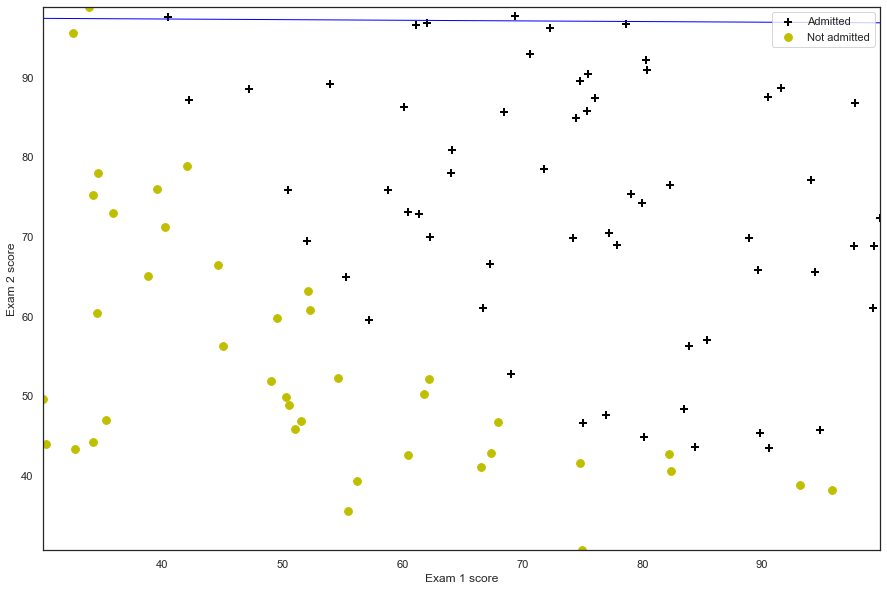

In [54]:
plt.figure(figsize = (15,10))
#plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
plotData(data, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

x1_min, x1_max = X[:,1].min(), X[:,1].max()
x2_min, x2_max = X[:,2].min(), X[:,2].max()

xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

#h = sigmoid(np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(theta_opt))
h = np.c_[np.ones((xx1.ravel().shape[0],1)), xx1.ravel(), xx2.ravel()].dot(theta_opt)
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')
plt.show()

## Regularized logistic regression

In [ ]:
data2 = loaddata('data/ex2data2.txt', ',')

In [ ]:
y = np.c_[data2[:,2]]
X = data2[:,0:2]

In [ ]:
plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

#### Polynomials

In [ ]:
# Note that this function inserts a column with 'ones' in the design matrix for the intercept.
poly = PolynomialFeatures(6)
XX = poly.fit_transform(data2[:,0:2])
XX.shape

#### Regularized Cost Function
#### $$ \large J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Vectorized Cost Function
#### $$ \large J(\theta) = -\frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\theta^T\theta$$

In [ ]:
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

#### Partial derivative

#### $$ \large \frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
#### Vectorized
#### $$ \large \frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m} X^T(g(X\theta)-y) + \frac{\lambda}{m}\theta_{j}$$
##### $$\text{Note: intercept parameter } \theta_{0} \text{ is not to be regularized}$$

In [ ]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
      
    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [ ]:
initial_theta = np.zeros(XX.shape[1])
costFunctionReg(initial_theta, 1, XX, y)

In [ ]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Decision boundaries
# Lambda = 0 : No regularization --> too flexible, overfitting the training data
# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias

for i, C in enumerate([0, 1, 100]):
    # Optimized costFunctionReg
    res2 = minimize(costFunctionReg, initial_theta, args=(C, XX, y), method=None, jac=gradientReg, options={'maxiter':3000})
    
    # Accuracy
    accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size    

    # Scatter plot of X,y
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # Plot decisionboundary
    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='g')       
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))